In [1]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import tensorflow as tf
import six
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

c:\Users\nagar\miniconda3\envs\newest_lstm_vae\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
c:\Users\nagar\miniconda3\envs\newest_lstm_vae\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\nagar\miniconda3\envs\newest_lstm_vae\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("q

In [2]:
class LSTM_Var_Autoencoder(object):

    def __init__(self, intermediate_dim=None, z_dim=None, n_dim=None, kulback_coef=0.1,
                 stateful=False):
        """
        Args:
        intermediate_dim : LSTM cells dimension.
        z_dim : dimension of latent space.
        n_dim : dimension of input data.
        statefull : if true, keep cell state through batches.
        """
        
        if not intermediate_dim or not z_dim or not n_dim:
            raise ValueError("You should set intermediate_dim, z_dim"
                             "(latent space) dimension and your input"
                             "third dimension, n_dim."
                             " \n            ")

        tf.reset_default_graph()

        self.z_dim = z_dim
        self.n_dim = n_dim
        self.intermediate_dim = intermediate_dim
        self.stateful = stateful
        self.input = tf.placeholder(tf.float32, shape=[None, None, self.n_dim])
        self.batch_size = tf.placeholder(tf.int64)
        self.kulback_coef = kulback_coef
        dataset = tf.data.Dataset.from_tensor_slices(self.input).repeat() \
            .batch(self.batch_size)
        self.batch_ = tf.placeholder(tf.int32, shape=[])
        self.ite = dataset.make_initializable_iterator()
        self.x = self.ite.get_next()
        self.repeat = tf.placeholder(tf.int32)

        def gauss_sampling(mean, sigma):
            with tf.name_scope("sample_gaussian"):
                eps = tf.random_normal(tf.shape(sigma), 0, 1, dtype=tf.float32)
                z = tf.add(mean, tf.exp(0.5*sigma) * eps)
                return z

        def get_state_variables(batch_size, cell):
            state_variables = []
            for state_c, state_h in cell.zero_state(batch_size, tf.float32):
                state_variables.append(tf.nn.rnn_cell.LSTMStateTuple(
                    (state_c), (state_h)))
            return tuple(state_variables)


        def get_state_update_op(state_variables, new_states):
            update_ops = []
            for state_variable, new_state in zip(state_variables, new_states):
                update_ops.extend([state_variable[0] == new_state[0],
                                   state_variable[1] == new_state[1]])
            return tf.tuple(update_ops)

        def get_state_reset_op(state_variables, cell, batch_size):
            zero_states = cell.zero_state(batch_size, tf.float32)
            return get_state_update_op(state_variables, zero_states)

        weights = {
            'z_mean': tf.get_variable(
                "z_mean",
                shape=[
                    self.intermediate_dim,
                    self.z_dim],
                initializer=tf.contrib.layers.xavier_initializer()),
            'log_sigma': tf.get_variable(
                "log_sigma",
                shape=[
                    self.intermediate_dim,
                    self.z_dim],
                initializer=tf.contrib.layers.xavier_initializer())}
        biases = {
            'z_mean_b': tf.get_variable("b_mean", shape=[self.z_dim],
                                        initializer=tf.zeros_initializer()),
            'z_std_b': tf.get_variable("b_log_sigma", shape=[self.z_dim],
                                       initializer=tf.zeros_initializer())
        }

        with tf.variable_scope("encoder"):
            with tf.variable_scope("LSTM_encoder"):
                lstm_layer = tf.nn.rnn_cell.LSTMCell(
                    self.intermediate_dim,
                    forget_bias=1,
                    initializer=tf.contrib.layers.xavier_initializer(),
                    activation=tf.nn.relu)

        if self.stateful:
            self.batch_ = tf.placeholder(tf.int32, shape=[])
            layer = tf.nn.rnn_cell.MultiRNNCell([lstm_layer])
            states = get_state_variables(self.batch_, layer)
            outputs, new_states = tf.nn.dynamic_rnn(
                layer, self.x, initial_state=states, dtype=tf.float32)
            self.update_op = get_state_update_op(states, new_states)
            self.reset_state_op = get_state_reset_op(
                states, lstm_layer, self.batch_)
        else:
            outputs, _ = tf.nn.dynamic_rnn(lstm_layer, self.x, dtype="float32")

        self.z_mean = tf.add(tf.matmul(
            outputs[:, -1, :], weights['z_mean']), biases['z_mean_b'])
        self.z_sigma = tf.nn.softplus(tf.add(tf.matmul(
            outputs[:, -1, :], weights['log_sigma']), biases['z_std_b']))
        self.z = gauss_sampling(self.z_mean, self.z_sigma)

        repeated_z = tf.keras.layers.RepeatVector(
            self.repeat, dtype="float32")(self.z)

        with tf.variable_scope("decoder"):
            if self.stateful:
                with tf.variable_scope('lstm_decoder_stateful'):
                    rnn_layers_ = [
                        tf.nn.rnn_cell.LSTMCell(
                            size,
                            initializer=tf.contrib.layers.xavier_initializer(),
                            forget_bias=1) for size in [
                            self.intermediate_dim,
                            n_dim]]
                    multi_rnn_cell_ = tf.nn.rnn_cell.MultiRNNCell(rnn_layers_)
                    states_ = get_state_variables(self.batch_, multi_rnn_cell_)
                self.x_reconstr_mean, new_states_ = tf.nn.dynamic_rnn(
                    cell=multi_rnn_cell_, inputs=repeated_z, initial_state=states_, dtype=tf.float32)
                self.update_op_ = get_state_update_op(states_, new_states_)
                self.reset_state_op_ = get_state_reset_op(
                    states_, multi_rnn_cell_, self.batch_)
            else:
                with tf.variable_scope('lstm_decoder_stateless'):
                    rnn_layers = [
                        tf.nn.rnn_cell.LSTMCell(
                            size,
                            initializer=tf.contrib.layers.xavier_initializer(),
                            forget_bias=1) for size in [
                            self.intermediate_dim,
                            n_dim]]
                    multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
                self.x_reconstr_mean, _ = tf.nn.dynamic_rnn(
                    cell=multi_rnn_cell, inputs=repeated_z, dtype=tf.float32)

    def _create_loss_optimizer(self, opt, **param):
        with tf.name_scope("MSE"):
            reconstr_loss = tf.reduce_sum(
                tf.losses.mean_squared_error(
                    self.x, self.x_reconstr_mean))
        with tf.name_scope("KL_divergence"):
            latent_loss = - 0.5 * tf.reduce_sum(1 + self.z_sigma
                                               - self.z_mean**2
                                               - tf.exp(self.z_sigma), 1)
            self._cost = tf.reduce_mean(reconstr_loss + self.kulback_coef*latent_loss)
            self.kl_divergence = tf.reduce_mean(latent_loss)
        # apply gradient clipping
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self._cost, tvars), 10)
        self.train_op = opt(**param).apply_gradients(zip(grads, tvars))

    def fit(
            self,
            X,
            learning_rate=0.001,
            batch_size=100,
            num_epochs=200,
            opt=tf.train.AdamOptimizer,
            REG_LAMBDA=0,
            grad_clip_norm=10,
            optimizer_params=None,
            verbose=True):      
        self.reconstr_losses = []  # List to store reconstruction losses
        self.kl_divergences = [] 
        if len(np.shape(X)) != 3:
            raise ValueError(
                'Input must be a 3-D array.'
                ' \n            Use input.reshape(-1,timesteps,1).')
        if optimizer_params is None:
            optimizer_params = {}
            optimizer_params['learning_rate'] = learning_rate
        else:
            optimizer_params = dict(six.iteritems(optimizer_params))

        self._create_loss_optimizer(opt, **optimizer_params)
        lstm_var = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES,
            scope='LSTM_encoder')
        self._cost += REG_LAMBDA * tf.reduce_mean(tf.nn.l2_loss(lstm_var))

        config = tf.ConfigProto(allow_soft_placement=True)
        config.gpu_options.allow_growth = True

        self.sess = tf.Session(config=config)
        init = tf.global_variables_initializer()
        self.sess.run(init)
        self.sess.run(
            self.ite.initializer,
            feed_dict={
                self.input: X,
                self.batch_size: batch_size})
        batches_per_epoch = int(np.ceil(len(X) / batch_size))

        print("\n")
        print("Training...")
        print("\n")
        start = timer()

        for epoch in range(num_epochs):
            train_error = 0
            kl_div_epoch = 0
            for step in range(batches_per_epoch):
                if self.stateful:
                    loss, kl_div, _, s, _ = self.sess.run(
                        [self._cost, self.kl_divergence, self.train_op, self.update_op, self.update_op_],
                        feed_dict={self.repeat: np.shape(X)[1], self.batch_: batch_size})
                else:
                    loss, kl_div = self.sess.run(
                        [self._cost, self.kl_divergence], 
                        feed_dict={self.repeat: np.shape(X)[1]})
                train_error += loss
                kl_div_epoch += kl_div  
            mean_loss = train_error / batches_per_epoch
            mean_kl_div = kl_div_epoch / batches_per_epoch
            
            self.reconstr_losses.append(mean_loss)
            self.kl_divergences.append(mean_kl_div)

            if step == (batches_per_epoch - 1):
                mean_loss = train_error / batches_per_epoch

                if self.stateful:
                    self.sess.run([self.reset_state_op],
                                  feed_dict={self.batch_: batch_size})
                    self.sess.run([self.reset_state_op_],
                                  feed_dict={self.batch_: batch_size})
            if epoch % 10 == 0 & verbose:
                print(
                    "Epoch {:^6} Loss {:0.5f}"  .format(
                        epoch + 1, mean_loss))
        end = timer()
        plt.figure(figsize=(10, 5))
        plt.plot(range(num_epochs), self.reconstr_losses, label="Reconstruction Loss")
        plt.plot(range(num_epochs), self.kl_divergences, label="KL Divergence")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training Losses")
        plt.show()

        print("\n")
        print("Training time {:0.2f} minutes".format((end - start) / (60)))

    def reconstruct(self, X, get_error=False):
        self.sess.run(
            self.ite.initializer,
            feed_dict={
                self.input: X,
                self.batch_size: np.shape(X)[0]})
        if self.stateful:
            _, _ = self.sess.run([self.reset_state_op, self.reset_state_op_], feed_dict={
                                self.batch_: np.shape(X)[0]})
            x_rec, kl_div, _, _ = self.sess.run(
                [self.x_reconstr_mean, self.kl_divergence, self.update_op, self.update_op_], 
                feed_dict={self.batch_: np.shape(X)[0], self.repeat: np.shape(X)[1]})
        else:
            x_rec, kl_div = self.sess.run(
                [self.x_reconstr_mean, self.kl_divergence], 
                feed_dict={self.repeat: np.shape(X)[1]})
        if get_error:
            squared_error = (x_rec - X)**2
            return x_rec, squared_error, kl_div
        else:
            return x_rec, kl_div


    def reduce(self, X):
        self.sess.run(
            self.ite.initializer,
            feed_dict={
                self.input: X,
                self.batch_size: np.shape(X)[0]})
        if self.stateful:
            _ = self.sess.run([self.reset_state_op], feed_dict={
                              self.batch_: np.shape(X)[0]})
            x, _ = self.sess.run([self.z, self.update_op], feed_dict={
                                 self.batch_: np.shape(X)[0], self.repeat: np.shape(X)[1]})
        else:
            x = self.sess.run(self.z)
        return x

# Training the word embeddings

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

df = pd.read_csv('spam_or_not_spam.csv')
df=df.dropna(subset=['email'])

stop_words = set(stopwords.words('english'))

custom_stop_words = {'URL', 'NUMBER'}
stop_words.update(custom_stop_words)

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return filtered_tokens

processed_sentences = df['email'].apply(preprocess_text).tolist()

model = Word2Vec(processed_sentences, vector_size=100, window=3, min_count=3, workers=4)

max_len = 30

# Convert sentences into their word embeddings, padded to max_len
def get_word_embeddings(sentence_tokens):
    embeddings = []
    for word in sentence_tokens:
        if word in model.wv:
            embeddings.append(model.wv[word])
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    while len(embeddings) < max_len:
        embeddings.append(np.zeros(model.vector_size))
    
    # Truncate the embeddings
    embeddings = embeddings[:max_len]
    
    return np.array(embeddings)

sentence_word_embeddings = np.array([get_word_embeddings(sentence) for sentence in processed_sentences])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nagar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nagar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Fitting the model



Training...


Epoch   1    Loss 0.26134
Epoch   11   Loss 0.12418


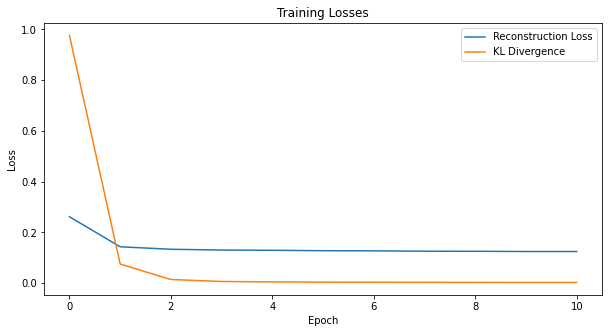



Training time 1.07 minutes


In [ ]:
vae = LSTM_Var_Autoencoder(intermediate_dim = 300,z_dim = 20, n_dim=100, stateful = True)
vae.fit(sentence_word_embeddings, learning_rate=0.001, batch_size = 100, num_epochs = 11, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01,
            grad_clip_norm=10, optimizer_params=None, verbose = True)

In [5]:
x_reconstructed, recons_error, kl_dive = vae.reconstruct(sentence_word_embeddings, get_error = True)
print("Average Reconstruction error: ", recons_error.mean())
print("KL divergence: ", kl_dive)

Average Reconstruction error:  0.1219629676445773
KL divergence:  0.0031118002


# Classifier Model

In [6]:
df['label'] = df['label'].astype(int)  

labels = to_categorical(df['label'], num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(sentence_word_embeddings, labels, test_size=0.2, random_state=42)

model_classifier = Sequential([
    LSTM(128, input_shape=(max_len, model.vector_size), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])


model_classifier.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
history = model_classifier.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, verbose=1)

Train on 1919 samples, validate on 480 samples
Epoch 1/10
1919/1919 [==============================] - 2s 1ms/step - loss: 0.4876 - acc: 0.8166 - val_loss: 0.4826 - val_acc: 0.8063
Epoch 2/10
1919/1919 [==============================] - 1s 487us/step - loss: 0.3786 - acc: 0.8385 - val_loss: 0.3446 - val_acc: 0.8063
Epoch 3/10
1919/1919 [==============================] - 1s 507us/step - loss: 0.2902 - acc: 0.8749 - val_loss: 0.2923 - val_acc: 0.8458
Epoch 4/10
1919/1919 [==============================] - 1s 502us/step - loss: 0.2684 - acc: 0.8791 - val_loss: 0.2650 - val_acc: 0.8854
Epoch 5/10
1919/1919 [==============================] - 1s 515us/step - loss: 0.2282 - acc: 0.8979 - val_loss: 0.2417 - val_acc: 0.8979
Epoch 6/10
1919/1919 [==============================] - 1s 596us/step - loss: 0.2232 - acc: 0.9119 - val_loss: 0.2078 - val_acc: 0.9062
Epoch 7/10
1919/1919 [==============================] - 1s 597us/step - loss: 0.2047 - acc: 0.9197 - val_loss: 0.2867 - val_acc: 0.8542
Epo

In [8]:
x_reconstructed_test, reconstr_error_test, kl_divergence_test = vae.reconstruct(X_test, get_error = True)

In [9]:
print("Reconstruction error test: ", reconstr_error_test.mean())
print("KL divergence test: ", kl_divergence_test)

Reconstruction error test:  0.12277943147633531
KL divergence test:  0.0030805464


# Running the classifier on the reconstructed data

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict the classes for the reconstructed test data
y_pred = model_classifier.predict(x_reconstructed_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

Accuracy:  0.8333333333333334


c:\Users\nagar\miniconda3\envs\newest_lstm_vae\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


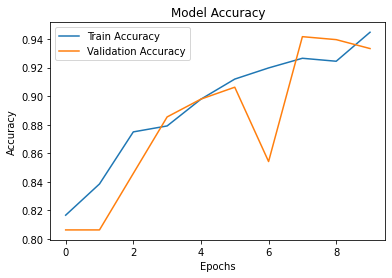

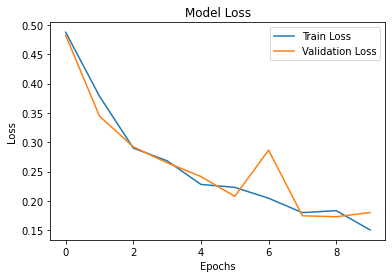

In [11]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
i=0
original_sentence = []
for vec in X_test[i]:  # Iterate over the embeddings for the original sentence
    similar_word = model.wv.most_similar([vec], topn=1)[0][0]
    original_sentence.append(similar_word)
original_sentence_str = ' '.join(original_sentence)

# Reconstruct the sentence from the reconstructed embeddings
reconstructed_sentence = []
for vec in x_reconstructed[i]:  # Iterate over the embeddings for the reconstructed sentence
    similar_word = model.wv.most_similar([vec], topn=1)[0][0]
    reconstructed_sentence.append(similar_word)
reconstructed_sentence_str = ' '.join(reconstructed_sentence)